# Time Series Clustering Demo

Using Piecewise Aggregate Approximation (PAA), Symbolic Aggregate Approximation (SAX), Edit Distance, and Dynamic Time Warping (DTW)

Suppose we have data on sensor measurements for a number of difference process runs. The goal is to perform unsupervised time series clustering on these runs so as to group together runs which exhibit similar behavior.

Data is based upon the Trace dataset found here: http://timeseriesclassification.com/description.php?Dataset=Trace

Generally, clustering based upon DTW distance offers the best performance; however, it can quickly become infeasible on large datasets given the computing resources required (it does not scale linearly). For this reason, SAX edit distance represents another viable option which drastically reduces the computing requirements while achieving simililar accuracy.

An example of how to implement SAX clustering is shown first, followed by use of DTW distance clustering. The differences in calculation times between the two is negligible given the small size of this toy dataset.

In [17]:
libname WINADO "C:\Users\winado\Desktop\Trace"; /*Define Libref*/

/*Create temporary dataset and assign run number*/
data trace;
    set WINADO.TRACE;
    run+1;
run;

/*Sort by label*/
proc sort data=trace;
	by label;
run;

/*Solution lookup*/
data solution;
	set trace;
    keep label run;
run;

title "Print first 10 records - Each row is a single run";
title2 "F[n] represents measurement taken at time n";
title3 "label represents true class label for series (pretend we don't actually know this)";
title4 "Goal is to cluster the runs in such a way that we are able to assign an accurate class label to each run";
proc print data=trace(
    obs=10
    keep=f1 f2 f3 f275 label run);
run;
title;title2;title3; /*Clear titles*/

title "Frequency of true label values";
proc freq data=solution;
    tables label;
run;
title;

Obs,F1,F2,F3,F275,label,run
1,0.61052,0.62126,0.69426,0.62217,1,1
2,0.62501,0.65294,0.62878,0.60855,1,2
3,0.65319,0.55613,0.67602,0.59041,1,3
4,0.59619,0.5526,0.59316,0.6173,1,4
5,0.60653,0.62571,0.63304,0.55859,1,5
6,0.57534,0.6185,0.60618,0.57317,1,6
7,0.57311,0.66785,0.62044,0.59814,1,7
8,0.58358,0.54549,0.58524,0.60546,1,8
9,0.53217,0.58283,0.63694,0.51815,1,9
10,0.62879,0.61587,0.65049,0.55126,1,10


run,sensor,t,label
1,0.61052,1,1
1,0.62126,2,1
1,0.69426,3,1
1,0.54682,4,1
1,0.57983,5,1

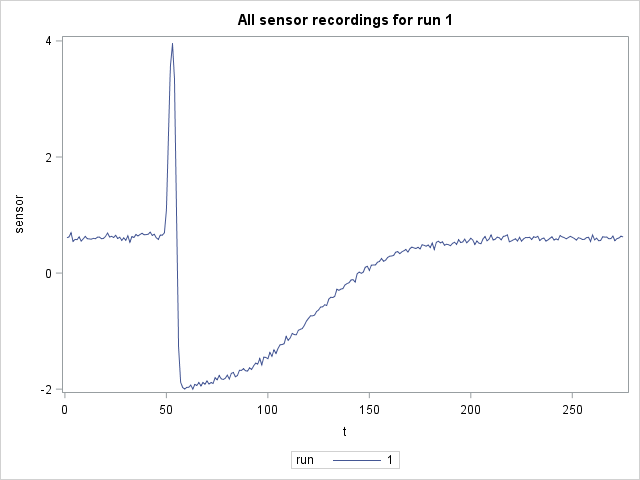
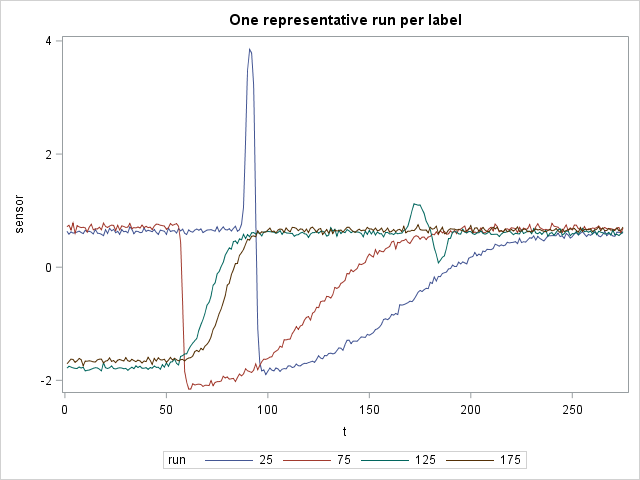

In [27]:
/*Transpose wide data to be long*/
proc transpose data=trace(drop=label) out=long1(drop=_name_ rename=(col1=sensor));
	var F: ;
	by run;
run;

/*Create time index t*/
data long2;
	set long1;
	by run;
	if first.run then t=0;
	t+1;
run;

/*Long dataset for graphing*/
proc sql;
	create table long as
	select *
	from long2 t1
	left join WINADO.solution t2
	on t1.run=t2.run
	order by run, t;
quit;

title "DATA:LONG - Now each row is a second";
title2 "Sensor represents variable measure at time t";
proc print noobs data=long(obs=5);
run;
title; title2;

title "All sensor recordings for run 1";
proc sgplot data=long (where=(run=1));
    series x=t y=sensor / group=run;
run;
title;

title "One representative run per label (raw values)";
proc sgplot data=long (where=(run in (25 75 125 175)));
    series x=t y=sensor / group=run;
run;
title;


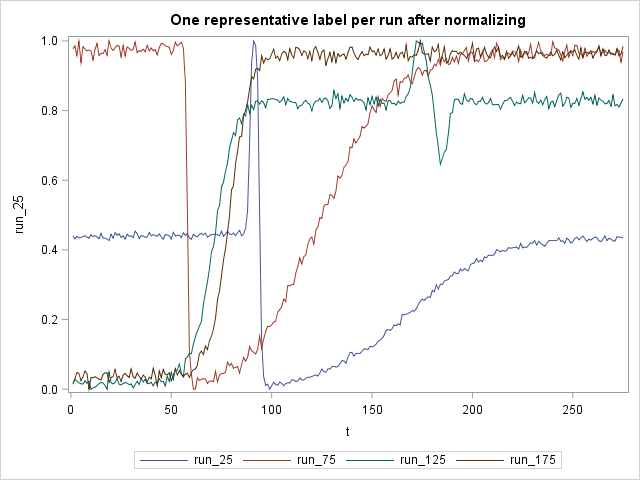

In [28]:
/*Get all runs, one column per run on common time index t*/
proc transpose data=trace out=transp(drop=_name_) prefix=run_;
	var F:;
run;

/*Create time index*/
data wide;
	length t 8.;
	set transp;
	t+1;
run;

/*Normalize all curves to between 0 and 1*/
proc stdize data=wide out=wide_std method=range;
	var run:;
run;

/*Plot normalized curves*/
title "One representative label per run after normalizing";
proc sgplot data=wide_std;
	series x=t y=run_25;
	series x=t y=run_75;
	series x=t y=run_125;
	series x=t y=run_175;
run;
title;

In [30]:
/*Apply SAX - 25 discrete time units*/
%let SAX_units=11; /*Number of SAX time increments used to cover length of time t*/
%let SAX_symbols=10; /*Number of SAX symbols to use - basically the max 'height' of the SAX representation*/

proc sql noprint;
	select count(t) into: t_duration from wide_std;
quit;

%let SAX_unit_length=%sysevalf(&t_duration/&SAX_units); /*Number of time units in each SAX unit*/
%put &=SAX_unit_length;

/*Create mapping table from numeric value to SAX symbol*/
data SAX_lookup(drop=char_rank);
  input symbol $1. num 8.;
  num=0;
  output; 

  do num=1 to &SAX_symbols;
  	char_rank=rank(symbol)+1;
    symbol=byte(char_rank);
    output;
  end;
  datalines;
a
run;

/*SAX format mapping for use after Piecewise Aggregate Approximation applied*/
title "SAX Numeric to Character Mapping";
proc print noobs data=SAX_lookup;
run;

/*Create SAX format*/
data SAX_format;
	set SAX_lookup;
	retain fmtname '$SAX' type 'C';
	start=put(num,2.);
	label=symbol;
	keep fmtname start label type;
run;

/*Load SAX format for later use*/
proc format cntlin=SAX_format;
run;

/*Time index mapping - reducing from max(t)=275 to max(s)=11*/
data s_index(keep=s);
	length s i 8.;
	if _n_=1 then s=0;
	do s=1 to &SAX_units;
		do i=2 to &SAX_unit_length;
			output;
		end;
		output;
	end;
run;

data s_index;
	set s_index;
	t+1;
run;

symbol,num
a,0
b,1
c,2
d,3
e,4
f,5
g,6
h,7
i,8
j,9


In [32]:
/*Get variable names - list of runs*/
proc contents data=wide_std out=cont(keep=name);
run;

/*Load macrovariable with list of runs to loop through*/
proc sql noprint;
	select name into: run_list separated by " " from cont where name ne 't';
quit;

/*Define Piecewise Aggregate Approximation Macro*/
%macro apply_PAA;
    proc sql;
        create table PAA as
        select *
        from WINADO.WIDE_STD t1
        left join s_index t2
        on t1.t=t2.t
        order by t;
    quit;

    proc sql noprint;
        create table PAA(drop=dummy) as
        select distinct
            s,
            /*t,*/
            /**,*/
            %do i=1 %to %sysfunc(countw(&run_list));
                %let this_run=%sysfunc(scan(&run_list,&i));
                    round(avg(&this_run),0.1)*10 as PAA_&this_run,
            %end;
            (1) as dummy
        from PAA
        group by s
        order by s;
quit;
%mend apply_PAA;

%apply_PAA; /*Call PAA macro*/

/*Ignore output immediately below - unable to suppress proc contents*/


s,PAA_run_1,PAA_run_2,PAA_run_3
1,4,4,4
2,4,4,4
3,2,4,4
4,1,5,4
5,2,0,3
6,3,1,0
7,4,2,1
8,4,3,3
9,4,4,4
10,4,4,4

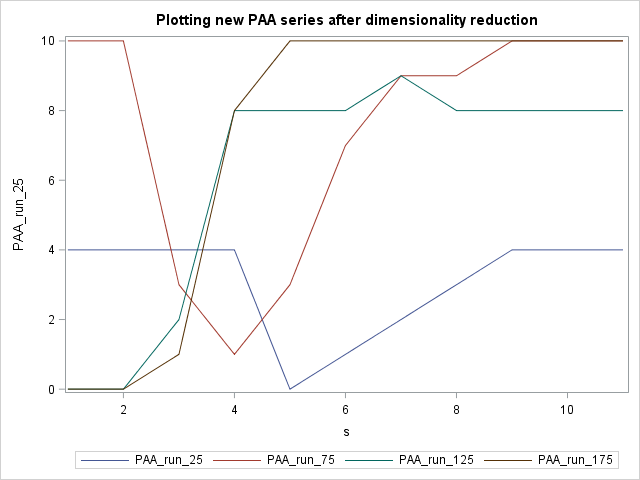

In [35]:
title "New PAA series for first three runs";
title2 "s is SAX time index";
proc print noobs data=PAA(keep=s PAA_run_1 PAA_run_2 PAA_run_3);
run;
title; title2;

title "Plotting new PAA series after dimensionality reduction";
proc sgplot data=PAA;
    series x=s y=PAA_run_25;
    series x=s y=PAA_run_75;
    series x=s y=PAA_run_125;
    series x=s y=PAA_run_175;
run;
title;

In [41]:
/*Transpose so 1 record per run*/
proc transpose data=PAA out=PAA_transp(rename=(_name_=PAA_run)) prefix=s;
	var PAA:;
run;

title "First three runs after applying PAA dimensionality reduction";
proc print data=PAA_transp(obs=3);
run;
title;

/*Apply SAX mappinng of numeric PAA to SAX character*/
%macro wrapper();
	data SAX_runs(keep=run SAX_series);
		length run 8. SAX_series $ &SAX_units;
		set PAA_transp;
		run=scan(PAA_run,3,'_');
		%do i=1 %to &SAX_units;
			s_&i=put(put(s&i,2.),$SAX.);
		%end;
		SAX_series=cats(of s_1-s_&SAX_units);
	run;
%mend;

%wrapper;

title "Frequency of SAX series representations";
proc freq data=SAX_runs order=freq;
	tables SAX_series;
	output out=SAX_freq;
run;
title;

In [42]:
/*Calculate Levenshtein edit distance between all pairs of SAX series*/
proc sql;
	create table SAX_distance as
 		select 
			t1.run as run,
			t2.run as run2,
			t1.SAX_series as series1, 
			t2.SAX_series as series2,
/* 			compged(t1.SAX_series,t2.SAX_series,999) as gedscore*/
			complev(t1.SAX_series,t2.SAX_series,&SAX_units) as levscore
 	from SAX_runs t1, SAX_runs t2
/* 	where t1.run < t2.run*/
	order by run, run2;
quit; 

title "Distance between runs (5 observations)";
proc print data=SAX_distance(obs=5);
run;
title;

/*Transpose to create distance matrix*/
proc transpose data=SAX_distance out=SAX_distance_matrix prefix=run_;
	var levscore;
	by run;
	id run2;
run;

Obs,run,run2,series1,series2,levscore
1,1,1,eecbcdeeeee,eecbcdeeeee,0
2,1,2,eecbcdeeeee,eeefabcdeee,5
3,1,3,eecbcdeeeee,eeeedabdeee,6
4,1,4,eecbcdeeeee,eeedabcdeee,5
5,1,5,eecbcdeeeee,eeefabcdeee,5


In [45]:
/*Cluster runs based on edit distance*/
proc cluster data=SAX_distance_matrix outtree=tree method=ward noprint;
   id run;
run;

/*Hierarchical clustering using 4 clusters*/
proc tree data=tree horizontal ncl=4 out=cluster;
run;

In [48]:
/*The following just formats the data to assign cluter name and label to each run*/

proc sort data=cluster;
	by cluster _name_;
run;

data cluster;
	length run 8.;
	set cluster;
	run=input(strip(_name_),8.);
run;


proc transpose data=wide_std out=transp(rename=(col1=sensor));
	var run:;
	by t;
run;

proc sort data=transp;
	by _name_ t;
run;

data transp;
	set transp;
	run=input(substr(_name_,5),8.);
run;


proc sql;
	create table clustered_runs as
	select *
	from transp t1
	left join cluster t2
	on t1.run=t2.run
	order by run, t;
quit;

title "Clustered Run Data";
proc print data=clustered_runs(obs=5);
run;
title;

Obs,t,_NAME_,sensor,run,CLUSTER,CLUSNAME
1,1,run_1,0.43843,1,1,CL4
2,2,run_1,0.44023,1,1,CL4
3,3,run_1,0.45249,1,1,CL4
4,4,run_1,0.42774,1,1,CL4
5,5,run_1,0.43328,1,1,CL4



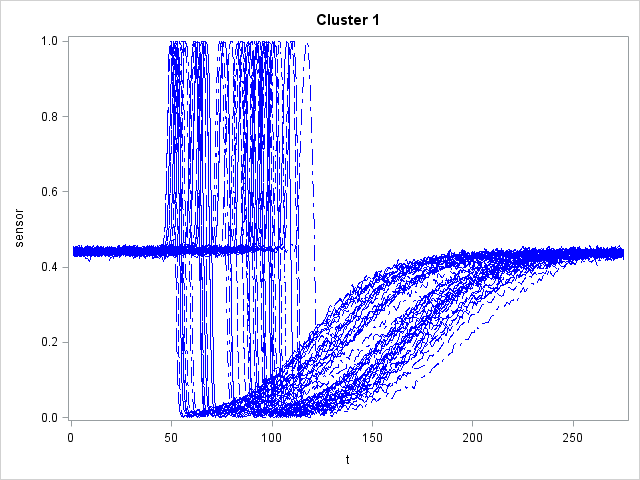
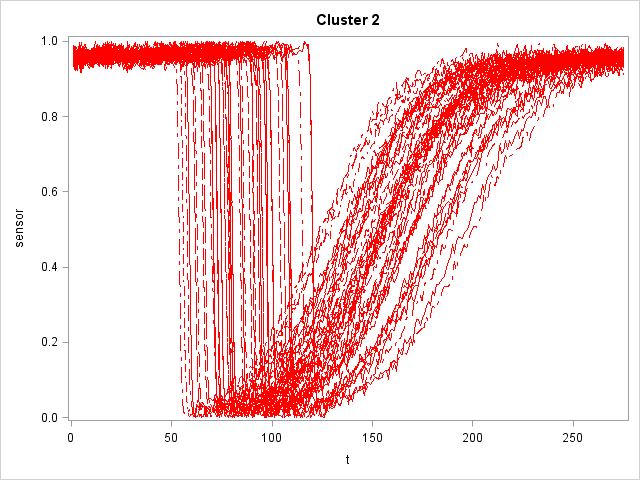
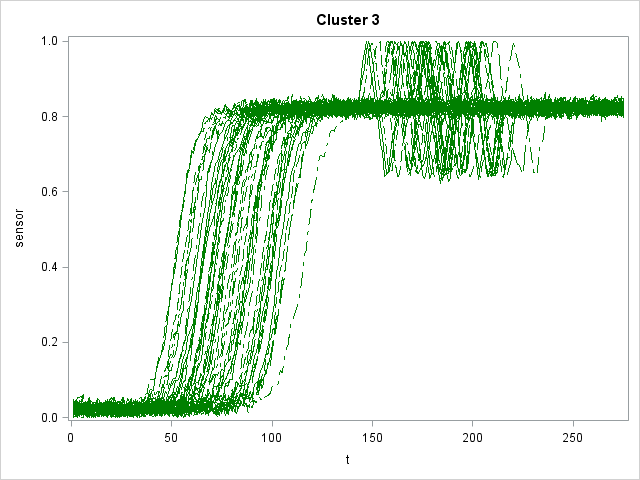
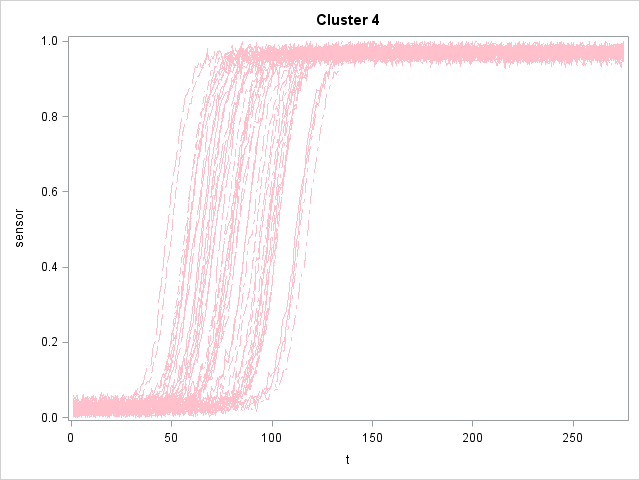

In [50]:
/*How did we do? Let's plot all runs by cluster*/
title "Cluster 1";
proc sgplot data=clustered_runs(where=(cluster=1));
	series x=t y=sensor / group=run lineattrs=(color=blue);
run;
title "Cluster 2";
proc sgplot data=clustered_runs(where=(cluster=2));
	series x=t y=sensor / group=run lineattrs=(color=red);
run;
title "Cluster 3";
proc sgplot data=clustered_runs(where=(cluster=3));
	series x=t y=sensor / group=run lineattrs=(color=green);
run;
title "Cluster 4";
proc sgplot data=clustered_runs(where=(cluster=4));
	series x=t y=sensor / group=run lineattrs=(color=pink);
run;
title;
/*We correctly clustered all of the runs by using SAX edit distance*/

# Now to to the same using DTW Distance

In [52]:
%let warp_constraint=35; /*Percent of warping path to allow*/

/*Calculate DTW Distance and output distance matrix*/
proc similarity data=wide_std outsum=simmatrix;
   target run: / measure=sqrdev
              compress=(localpct=&warp_constraint globalpct=&warp_constraint)
              expand=(localpct=&warp_constraint globalpct=&warp_constraint);
run;

/*Perform hierarchical clustering*/
proc cluster data=simmatrix(drop=_status_) outtree=tree method=ward noprint;
   id _input_;
run;

/*Split tree into 4 clusters*/
proc tree data=tree horizontal ncl=4 out=cluster;
run;

proc sort data=cluster;
	by cluster _name_;
run;

proc sql;
	create table clustered_runs2 as
	select *
	from transp t1
	left join cluster t2
	on t1._name_=t2._name_
	order by _name_, t;
quit;



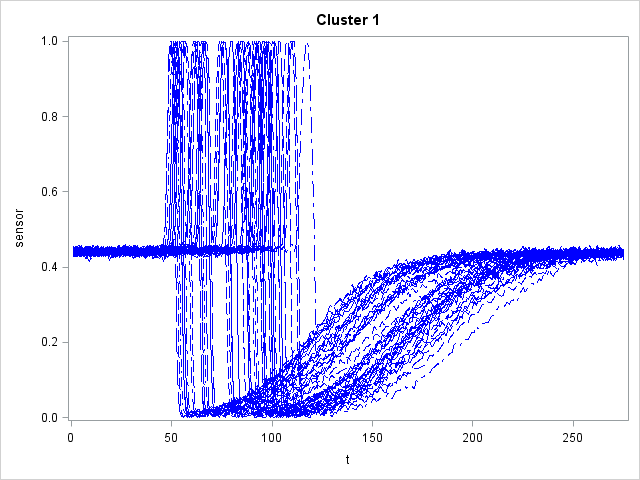
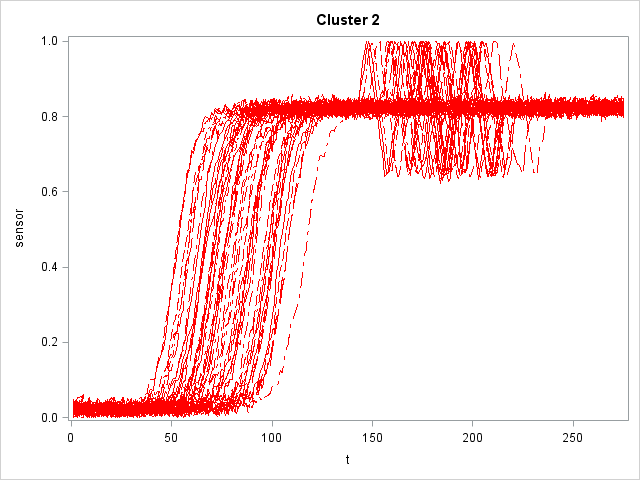
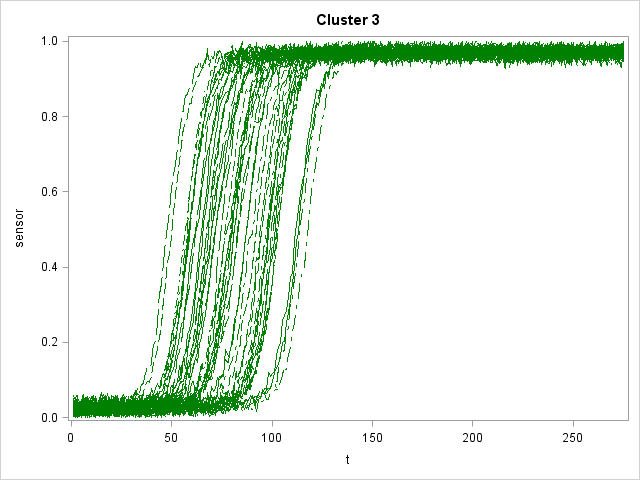
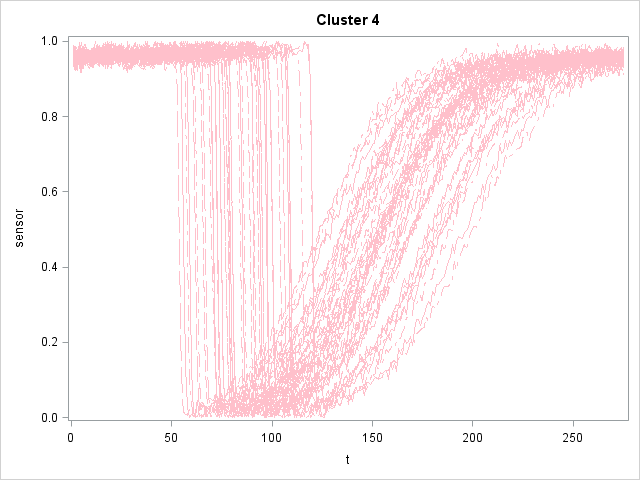

In [54]:
/*Again plot all runs by cluster*/
title "Cluster 1";
proc sgplot data=clustered_runs2(where=(cluster=1));
	series x=t y=sensor / group=run lineattrs=(color=blue);
run;
title "Cluster 2";
proc sgplot data=clustered_runs2(where=(cluster=2));
	series x=t y=sensor / group=run lineattrs=(color=red);
run;
title "Cluster 3";
proc sgplot data=clustered_runs2(where=(cluster=3));
	series x=t y=sensor / group=run lineattrs=(color=green);
run;
title "Cluster 4";
proc sgplot data=clustered_runs2(where=(cluster=4));
	series x=t y=sensor / group=run lineattrs=(color=pink);
run;
title;
/*We again correctly clustered all of the runs by using DTW distance*/